# Testing trackastra

In [9]:
import torch
import btrack
import os
import zarr
from trackastra.model import Trackastra
from trackastra.tracking import graph_to_ctc, graph_to_napari_tracks
from trackastra.data import example_data_bacteria

In [21]:
acq_ID = (3, 6)
expt_ID = 'ND0003'
base_dir = f'/mnt/SYNO/macrohet_syno/data/{expt_ID}/'
image_dir = os.path.join(base_dir, f'acquisition/zarr/{acq_ID}.zarr')
zarr_group = zarr.open(image_dir, mode='r')
imgs = zarr_group.images[:,1,0,...]
tracks_fn = os.path.join(base_dir, f'labels/cpv3/{acq_ID}.h5')
with btrack.io.HDF5FileHandler(tracks_fn, 'r') as hdf:
        masks = hdf.segmentation

[INFO][2024/06/25 04:38:05 pm] Opening HDF file: /mnt/SYNO/macrohet_syno/data/ND0003/labels/cpv3/(3, 6).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/data/ND0003/labels/cpv3/(3, 6).h5...
[INFO][2024/06/25 04:38:24 pm] Loading segmentation (154, 6048, 6048)
INFO:btrack.io.hdf:Loading segmentation (154, 6048, 6048)
[INFO][2024/06/25 04:38:24 pm] Closing HDF file: /mnt/SYNO/macrohet_syno/data/ND0003/labels/cpv3/(3, 6).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/data/ND0003/labels/cpv3/(3, 6).h5


In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load a pretrained model
model = Trackastra.from_pretrained("general_2d", device=device)

# or from a local folder
# model = Trackastra.from_folder('path/my_model_folder/', device=device)

# Track the cells
track_graph = model.track(imgs, masks, mode="greedy")  # or mode="ilp", or "greedy_nodiv"


# Write to cell tracking challenge format
ctc_tracks, masks_tracked = graph_to_ctc(
      track_graph,
      masks,
      outdir="tracked",
)

INFO:trackastra.model.model:Loading model state from /home/dayn/.trackastra/.models/general_2d/model.pt
INFO:trackastra.model.model_api:Predicting weights for candidate graph


/home/dayn/.trackastra/.models/general_2d already downloaded, skipping.
Using device cuda


INFO:trackastra.data.wrfeat:Extracting features from 154 detections
INFO:trackastra.data.wrfeat:Using single process for feature extraction
Extracting features: 100%|███████████████████████████████████████████████████████████| 154/154 [08:34<00:00,  3.34s/it]
INFO:trackastra.model.model_api:Building windows
Building windows: 100%|███████████████████████████████████████████████████████████| 151/151 [00:00<00:00, 12246.74it/s]
INFO:trackastra.model.model_api:Predicting windows
Computing associations: 100%|████████████████████████████████████████████████████████| 151/151 [00:15<00:00,  9.64it/s]
INFO:trackastra.model.model_api:Running greedy tracker
INFO:trackastra.tracking.tracking:Build candidate graph with delta_t=1
INFO:trackastra.tracking.tracking:Added 60541 vertices, 60418 edges                                                    
INFO:trackastra.tracking.tracking:Running greedy tracker
Saving masks: 100%|██████████████████████████████████████████████████████████████████| 154/154 [0

In [23]:
# Visualise in napari
napari_tracks, napari_tracks_graph, _ = graph_to_napari_tracks(track_graph)

import napari
v = napari.Viewer()
v.add_image(imgs)
v.add_labels(masks_tracked)
v.add_tracks(data=napari_tracks, graph=napari_tracks_graph)

100%|███████████████████████████████████████████████████████████████████████████| 7633/7633 [00:00<00:00, 48260.68it/s]


<Tracks layer 'napari_tracks' at 0x7f55db725150>

# Compare to previous tracks

In [25]:
with btrack.io.HDF5FileHandler(tracks_fn, 'r') as hdf:
        tracks = hdf.tracks

[INFO][2024/06/26 09:43:57 am] Opening HDF file: /mnt/SYNO/macrohet_syno/data/ND0003/labels/cpv3/(3, 6).h5...
INFO:btrack.io.hdf:Opening HDF file: /mnt/SYNO/macrohet_syno/data/ND0003/labels/cpv3/(3, 6).h5...
[INFO][2024/06/26 09:43:58 am] Loading tracks/obj_type_1
INFO:btrack.io.hdf:Loading tracks/obj_type_1
[INFO][2024/06/26 09:43:58 am] Loading LBEP/obj_type_1
INFO:btrack.io.hdf:Loading LBEP/obj_type_1
[INFO][2024/06/26 09:43:58 am] Loading objects/obj_type_1 (55107, 5) (55107 filtered: None)
INFO:btrack.io.hdf:Loading objects/obj_type_1 (55107, 5) (55107 filtered: None)
[INFO][2024/06/26 09:43:59 am] Closing HDF file: /mnt/SYNO/macrohet_syno/data/ND0003/labels/cpv3/(3, 6).h5
INFO:btrack.io.hdf:Closing HDF file: /mnt/SYNO/macrohet_syno/data/ND0003/labels/cpv3/(3, 6).h5


In [27]:
napari_btracks, _, _ = btrack.utils.tracks_to_napari(tracks)


In [28]:
v.add_tracks(napari_btracks, scale = (5.04, 5.04))

<Tracks layer 'napari_btracks' at 0x7f59c372d270>

In [35]:
import seaborn as sns
import numpy as np

<Axes: ylabel='Count'>

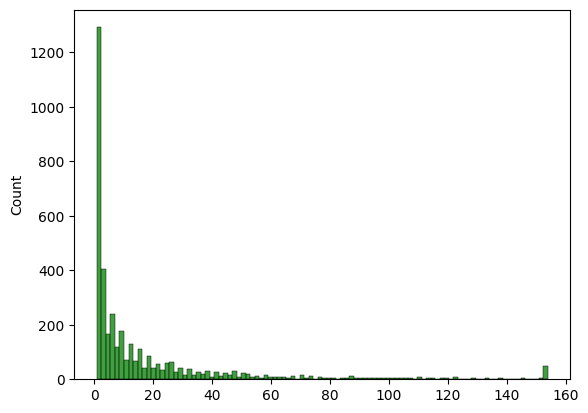

In [37]:
sns.histplot([len(t) for t in tracks], color='green', bins = 100)

In [38]:
# Extract unique IDs
unique_ids = np.unique(napari_tracks[:, 0])

# Calculate track lengths
track_lengths = []
for uid in unique_ids:
    track_length = len(np.unique(napari_tracks[napari_tracks[:, 0] == uid][:, 1]))
    track_lengths.append(track_length)



<Axes: ylabel='Count'>

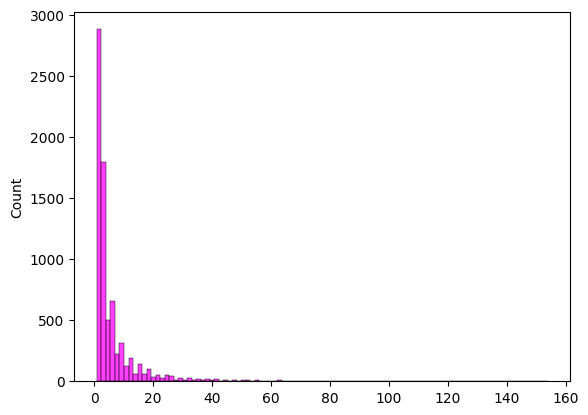

In [39]:
sns.histplot(track_lengths, color = 'magenta', bins = 100)